In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings('ignore')

import cv2
import PIL

# import ML/DL libraries
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn import utils, svm, metrics
from scipy import interp
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.naive_bayes import GaussianNB
from tf_explain.core.grad_cam import GradCAM


from keras.preprocessing.image import ImageDataGenerator # used for image augmentation
from tensorflow.keras.applications.inception_v3 import preprocess_input


import tensorflow as tf
# used for building and training a new model
from keras import Sequential, Model
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from keras.applications import VGG16, ResNet50

# import functions from other python files
from code_files.imagePreprocessing import * 

Total number of images:  352


<AxesSubplot:ylabel='count'>

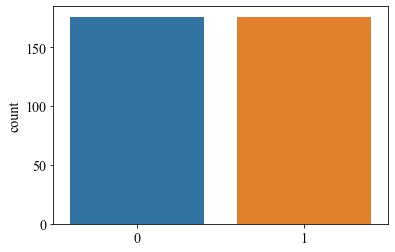

In [11]:
# ********************************
#           IMPORT IMAGES
# ********************************
# import images (and labels) and store in dataframe
# FLAG: set the path to the desired dataset
data_path = 'C:/Users/Rebecca/Documents/Virginia_Tech/Research/database-images/database-images/raw_skel/'  

trainImgs = pd.DataFrame()
trainArray = []

img_path = []
lbl = []
lblName = []
run_balanced=True
for group in os.listdir(data_path): # group = healthy or parkinsons
    # for img in os.listdir(os.path.join(data_path, group)):
        path = os.path.join(data_path, group) # add ,img to the end for original dataset


        # convert the image and store as a matrix
        drawing = cv2.imread(path)
        drawing = cv2.resize(drawing, (224,224))
        

        # store the labels
        if 'H' in group: #if group == 'healthy':
            if run_balanced:
                if len(lbl)-np.count_nonzero(lbl)<176:
                    lbl.append(0)
                    lblName.append('healthy')
                    trainArray.append(drawing)
                    img_path.append(path) 
            else:
                lbl.append(0)
                lblName.append('healthy')
                trainArray.append(drawing)
                img_path.append(path) 
        else:
            lbl.append(1)
            lblName.append('parkinsons')
            trainArray.append(drawing)
            img_path.append(path) 

        

trainLbls = lbl
trainImgs['image'] = img_path
trainImgs['label'] = lblName


# shuffle the data
# trainImgs, trainArray, trainLbls = utils.shuffle(trainImgs, trainArray, trainLbls)

# convert labels to categorical for training model
trainLbls_categorical = tf.keras.utils.to_categorical(trainLbls)
# print("Labels of first 5 images: \n", trainLbls_categorical[0:5])

# used in the feature extraction section
numImgs = len(trainLbls)
print("Total number of images: ", numImgs)

sns.countplot(trainLbls)

In [12]:
# ******************************
#         IMPORT MODEL
# ******************************
# import ResNet-50 pretrained model 
model = ResNet50(weights='imagenet', include_top=False,input_shape=(224,224,3)) # setting include_top=False removes the fully connected layers of the model
# model.summary()

# summarize feature map shapes # FLAG: can uncomment for feature visualization
for i in range(len(model.layers)):
    layer=model.layers[i]
    # check for conv layer
    if 'conv' in layer.name:
        print(i, layer.name, layer.output.shape)

1 conv1_pad (None, 230, 230, 3)
2 conv1_conv (None, 112, 112, 64)
3 conv1_bn (None, 112, 112, 64)
4 conv1_relu (None, 112, 112, 64)
7 conv2_block1_1_conv (None, 56, 56, 64)
8 conv2_block1_1_bn (None, 56, 56, 64)
9 conv2_block1_1_relu (None, 56, 56, 64)
10 conv2_block1_2_conv (None, 56, 56, 64)
11 conv2_block1_2_bn (None, 56, 56, 64)
12 conv2_block1_2_relu (None, 56, 56, 64)
13 conv2_block1_0_conv (None, 56, 56, 256)
14 conv2_block1_3_conv (None, 56, 56, 256)
15 conv2_block1_0_bn (None, 56, 56, 256)
16 conv2_block1_3_bn (None, 56, 56, 256)
17 conv2_block1_add (None, 56, 56, 256)
18 conv2_block1_out (None, 56, 56, 256)
19 conv2_block2_1_conv (None, 56, 56, 64)
20 conv2_block2_1_bn (None, 56, 56, 64)
21 conv2_block2_1_relu (None, 56, 56, 64)
22 conv2_block2_2_conv (None, 56, 56, 64)
23 conv2_block2_2_bn (None, 56, 56, 64)
24 conv2_block2_2_relu (None, 56, 56, 64)
25 conv2_block2_3_conv (None, 56, 56, 256)
26 conv2_block2_3_bn (None, 56, 56, 256)
27 conv2_block2_add (None, 56, 56, 256)
28 

In [4]:
# ******************************
#     VISUALIZE FEATURE MAPS
# ******************************
# choose second conv block from each layer to display
blocks = [4, 17]
output_layers = [model.layers[i].output for i in blocks]
# redefine model to output right after each conv layer
vis_model = Model(inputs=model.inputs, outputs=output_layers)

train_feat, test_feat, train_lbls, test_lbls = train_test_split(trainArray, trainLbls, test_size=0.2, random_state=42)

# select images to save visualizations for and put them in an array
# manually choose two healthy and two parkinsons
img2vis = np.array([test_feat[0], test_feat[1]])

# iterate through each image and save the feature maps
for i in range(len(img2vis)):
    img = np.expand_dims(img2vis[i], axis=0)
    img = preprocess_input(img)
    feature_maps = vis_model.predict(img)
    blocknum = 0

    for fmap in feature_maps:
        fmap_size = np.shape(fmap)
        # determine the number of images to plot
        if fmap_size[3]==64:
            rows=8;cols=8
        elif fmap_size[3]==128:
            rows=16; cols=8
        elif fmap_size[3]==256:
            rows=16;cols=16
        else:
            rows=16;cols=32

        itr = 1
        fig, ax = plt.subplots(rows,cols, figsize=(75,75))
        title = 'Image_' + str(i) + 'fmap: ' + str(np.shape(fmap))
        fig.suptitle(title)

        for r in range(rows):
            for c in range(cols):
                ax[r][c].imshow(fmap[0,:,:,itr-1], cmap='gray')
                itr += 1

        plt.tight_layout()
        savename = 'Image_' + str(i) + '_block_' +  str(blocks[blocknum]) + '_vgg16_orig_HT.png'
        print(savename)
        fig.savefig(savename)
        plt.close()
        blocknum += 1

1/1 [==============================] - 0s 277ms/step
Image_0_block_4_vgg16_orig_HT.png
Image_0_block_17_vgg16_orig_HT.png
1/1 [==============================] - 0s 37ms/step
Image_1_block_4_vgg16_orig_HT.png
Image_1_block_17_vgg16_orig_HT.png


In [13]:
# ******************************************************************************************************
# ------------------------------------------------------------------------------------------------------
#                                           CLASSIFICATION  
# ------------------------------------------------------------------------------------------------------
# ******************************************************************************************************

# 1. VGG16 or RestNet50
# 2. SVM
# 3. Naive Bayes
# 4. Random Forest

# .........................
#    FEATURE EXTRACTION
# .........................
# define a function that will extract the features from conv network
def extract_features(imgs, num_imgs):
    datagen = ImageDataGenerator(rescale=1./255) # define to rescale pixels in image
    batch_size = 32
    
    features = np.zeros(shape=(num_imgs, 7,7,2048)) # shape equal to output of convolutional base 
    lbls = np.zeros(shape=(num_imgs,2))

    # preprocess data
    generator = datagen.flow_from_dataframe(imgs, x_col = 'image', y_col='label', target_size=(224,224), class_mode='categorical', batch_size=batch_size)

    # Pass data through convolutional base
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = model.predict(inputs_batch)
        features[i * batch_size: (i + 1) * batch_size] = features_batch
        lbls[i * batch_size: (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= num_imgs:
            break
    return features, lbls

# extract features for both the trainImgs and testImgs
data, labels = extract_features(trainImgs, numImgs)

Found 352 validated image filenames belonging to 2 classes.
1/1 [==============================] - 4s 4s/step


<AxesSubplot:ylabel='count'>

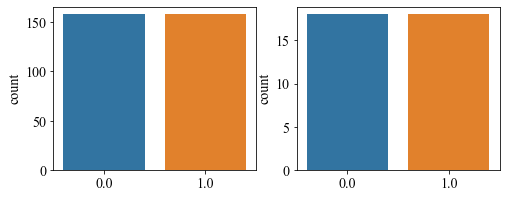

In [14]:
# =============================
#       Train on Fully Connected Layers
# =============================
# split into training and testing data
rs=42
train_feat, test_feat, train_lbls, test_lbls = train_test_split(data, labels, test_size=0.1, random_state=rs, stratify=labels)
# trainArray, testArray, _,_ = train_test_split(trainArray, trainLbls, test_size=0.1, random_state=rs, stratify=trainLbls)

fig, ax = plt.subplots(1,2, figsize=(8,3))
sns.countplot(train_lbls[:,1], ax=ax[0])
sns.countplot(test_lbls[:,1], ax=ax[1])

In [27]:
def raw_feature_classification(train_feat, test_feat, train_lbls, test_lbls, classifier):

    if classifier=='rn50':
        # train pre-trained features
        # evaluate on VGG16 classifier (using cross validation)
        # define a function that will fit the model
        def defineModel(size): # size is the dimension of the last layer in the pretrained model
            model = Sequential()
            model.add(GlobalAveragePooling2D(input_shape=(size,size,2048)))
            # global average pooling is used instead of fully connected layers on top of the feature maps
            # it takes the average of each feature map and the resulting layer is fed directly into the softmax layer
            model.add(Dense(2, activation='softmax'))
            # model.summary()

            opt = tf.keras.optimizers.Adam(learning_rate=1e-4)  # use the Adam optimizer and set an effective learning rate 
            model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
            return model


        def fit_and_evaluate(train_feat, train_lbls, val_feat, val_lbls, epochs):
            model = None
            model = defineModel(7) # FLAG: need to set the size based on the last layer
            trained_model = model.fit(train_feat, train_lbls, batch_size=32, epochs=epochs, validation_data=(val_feat, val_lbls), callbacks=model_chkpt, verbose=0)

            # testScore = model.evaluate(test_feat, test_lbls)
            return trained_model

        def importModel(filename, test_data, test_lbl):
            modelPath = filename
            testModel = tf.keras.models.load_model(modelPath)

            # # confusion matrix
            # cfm = confusion_matrix(label_pred, pred)
            # # print(cfm)

            # tpr = cfm[0][0] / (cfm[0][0] + cfm[1][0])
            # tnr = cfm[1][1] / (cfm[1][1] + cfm[0][1])

            return testModel

        # train with k-fold validation
        model_history = []
        epochs = 250

        plot_model_history=False

    # num_val_samples = int(np.ceil(len(trainArray) * 0.20))
    # k = int(np.floor(len(trainArray) / num_val_samples))
    rs=42 # set the random state
    cv = StratifiedKFold(n_splits=8, shuffle=True, random_state=rs) # this is approximately a 80-20 split

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0,1,100)

    acc = []
    cfm_storage = []
    tpr_storage = []
    tnr_storage = []
    prec = []
    recall = []
    f1 = []

    i = 1
    plt.figure(figsize=(10,8))
    for train, val in cv.split(train_feat, train_lbls[:,1]):
        print('Fold: ', i, end='\r')

        # split data into training and validation
        x_train = train_feat[train]
        x_val   = train_feat[val]
        y_train = train_lbls[train]
        y_val   = train_lbls[val]

        if classifier=='rn50':
            # define model checkpoint callback
            ckpt_name = '20230105_folador_skel_bal_raw_fold' + str(i) + '.h5'
            model_chkpt = tf.keras.callbacks.ModelCheckpoint(ckpt_name, verbose=0, save_best_only=True)
        
            kfold_model = fit_and_evaluate(x_train, y_train, x_val, y_val, epochs=epochs)
            model_history.append(kfold_model)
            model = importModel(ckpt_name, test_feat, test_lbls)

            loss, accuracy = model.evaluate(np.array(test_feat), test_lbls, verbose=0)
            print("Loss: ", loss, "| Accuracy: ", accuracy)

            # ROC curve
            probas_ = model.predict(np.array(test_feat)).ravel()
            # compute the ROC curve and area under the curve
            fpr, tpr, thresholds = metrics.roc_curve(test_lbls.ravel(), probas_)

        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0]=0.0
        roc_auc = metrics.auc(fpr, tpr)
        aucs.append(roc_auc)
        plt.plot(fpr, tpr, lw=1, alpha=0.3)

        # classification report
        pred = model.predict(np.array(test_feat))
        pred = np.argmax(pred, axis=1)
        label_pred = np.argmax(test_lbls, axis=1)
        # # print(classification_report(label_pred, pred))

        # calculate accuracy
        acc.append(accuracy)
        cfm = confusion_matrix(label_pred, pred)
        clf_report  = metrics.classification_report(label_pred, pred, output_dict=True)
        cfm_storage.append(cfm)
        tpr_storage.append(cfm[0][0] / (cfm[0][0] + cfm[1][0]))
        tnr_storage.append(cfm[1][1] / (cfm[1][1] + cfm[0][1]))
        prec.append(clf_report['macro avg']['precision'])
        recall.append(clf_report['macro avg']['recall'])
        f1.append(clf_report['macro avg']['f1-score'])

        i+=1

    plt.plot([0,1],[0,1], linestyle='--', lw=2, color='k', label='Baseline', alpha=0.8)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = metrics.auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    plt.plot(mean_fpr, mean_tpr, color='b',
            label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    plt.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                    label=r'$\pm$ 1 std. dev.')

    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend(loc="lower right")
    plt.rcParams.update({'font.size': 14})
    plt.rcParams.update({'font.family': 'Times New Roman'})
    plt.show()

    # plot model
    if plot_model_history:
        # plot the accuracy and loss functions for each fold
        color = ['blue', 'black', 'red', 'green','orange', 'cyan', 'grey', 'yellow', 'fuchsia']
        f, ax = plt.subplots(2, 8, figsize=(35,6))
        for i in range(8):
            ax[0][i].plot(model_history[i].history['accuracy'], label='train acc', color=color[i])
            ax[0][i].plot(model_history[i].history['val_accuracy'], label='val acc', linestyle= ':', color=color[i])
            ax[0][i].axis([-10,epochs, .2, 1.1])
            ax[0][i].legend()

            subplot_title = 'k = ' + str(i+1)
            ax[0][i].title.set_text(subplot_title)

        for i in range(8):
            ax[1][i].plot(model_history[i].history['loss'], label='train loss', color=color[i])
            ax[1][i].plot(model_history[i].history['val_loss'], label='val loss', linestyle= ':', color=color[i])
            ax[1][i].axis([-10,epochs, .0, 1.1])
            ax[1][i].legend()

    return acc, cfm, tpr_storage, tnr_storage, prec, recall, f1

Loss:  0.5369417071342468 | Accuracy:  0.7777777910232544
2/2 [==============================] - 0s 3ms/step
Loss:  0.5414347052574158 | Accuracy:  0.7777777910232544
2/2 [==============================] - 0s 3ms/step
Loss:  0.5370261073112488 | Accuracy:  0.75
2/2 [==============================] - 0s 3ms/step
Loss:  0.5312624573707581 | Accuracy:  0.75
2/2 [==============================] - 0s 5ms/step
Loss:  0.5413743257522583 | Accuracy:  0.75
2/2 [==============================] - 0s 2ms/step
Loss:  0.5356383323669434 | Accuracy:  0.7777777910232544
2/2 [==============================] - 0s 2ms/step
Loss:  0.5402122139930725 | Accuracy:  0.75
2/2 [==============================] - 0s 3ms/step
Loss:  0.5426546931266785 | Accuracy:  0.7777777910232544
2/2 [==============================] - 0s 3ms/step


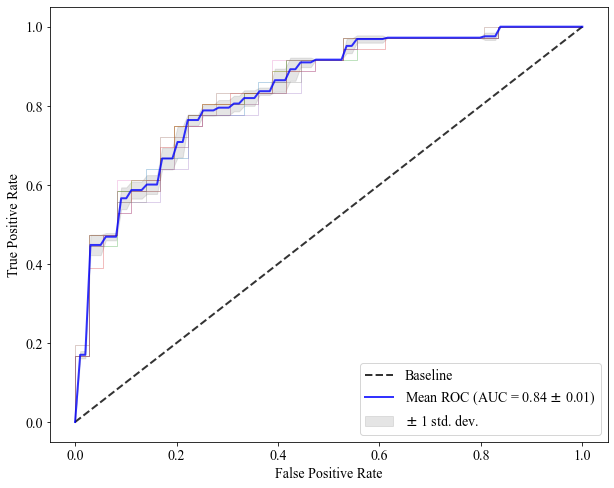

ValueError: not enough values to unpack (expected 8, got 7)

In [28]:
fcl_acc, fcl_cfm, fcl_tpr, fcl_tnr, fcl_prec, fcl_recall, fcl_f1 = raw_feature_classification(train_feat, test_feat, train_lbls, test_lbls, 'rn50')
print(fcl_acc)
print('Accuracy - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_acc), np.max(fcl_acc), np.mean(fcl_acc), np.std(fcl_acc)))
print('TPR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_tpr), np.max(fcl_tpr), np.mean(fcl_tpr), np.std(fcl_tpr)))
print('TNR - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_tnr), np.max(fcl_tnr), np.mean(fcl_tnr), np.std(fcl_tnr)))
print('Precision - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_prec), np.max(fcl_prec), np.mean(fcl_prec), np.std(fcl_prec)))
print('Recall - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_recall), np.max(fcl_recall), np.mean(fcl_recall), np.std(fcl_recall)))
print('f1-score - min: %0.4f, max: %0.4f, avg: %0.4f, std. dev: %0.4f' % (np.min(fcl_f1), np.max(fcl_f1), np.mean(fcl_f1), np.std(fcl_f1)))

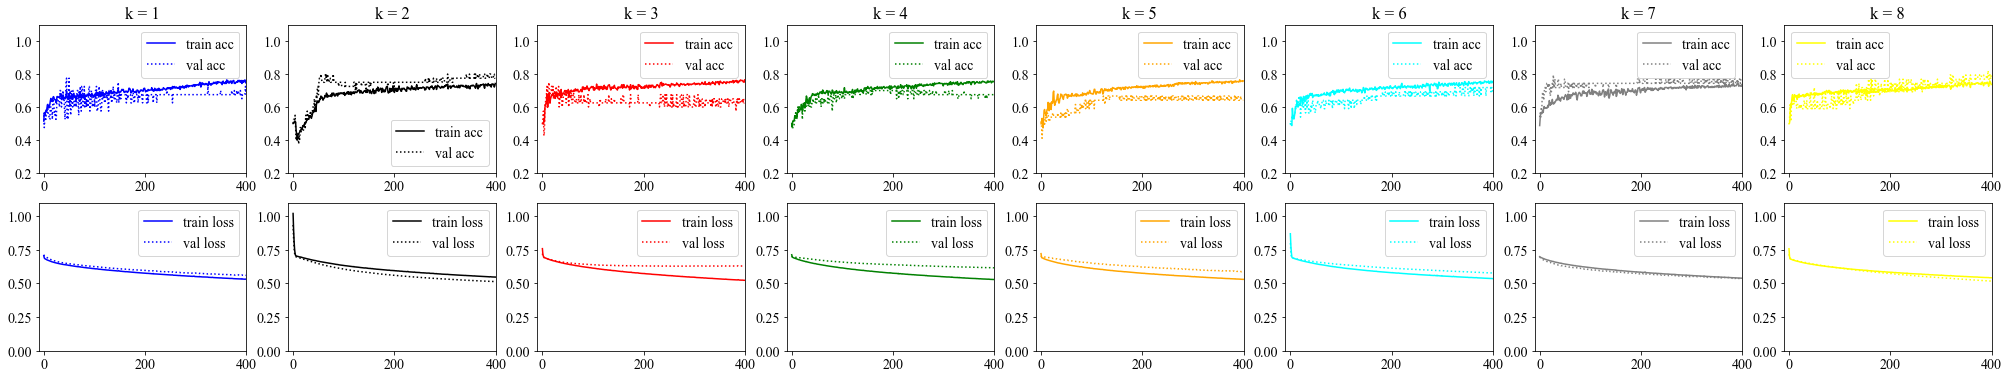

In [14]:
print(fcl_cfm)

[array([[29, 10],
       [19, 19]], dtype=int64), array([[29,  9],
       [11, 28]], dtype=int64), array([[28, 10],
       [ 4, 35]], dtype=int64), array([[32,  6],
       [13, 26]], dtype=int64), array([[33,  6],
       [20, 18]], dtype=int64), array([[27, 11],
       [11, 28]], dtype=int64), array([[27, 12],
       [ 7, 31]], dtype=int64), array([[34,  5],
       [13, 25]], dtype=int64), array([[28, 10],
       [ 9, 30]], dtype=int64), array([[32,  7],
       [ 8, 30]], dtype=int64), array([[30,  9],
       [ 6, 32]], dtype=int64), array([[30,  9],
       [ 8, 30]], dtype=int64), array([[32,  6],
       [13, 26]], dtype=int64), array([[28, 11],
       [ 7, 31]], dtype=int64), array([[32,  6],
       [ 6, 33]], dtype=int64), array([[28, 11],
       [18, 20]], dtype=int64), array([[32,  7],
       [ 6, 32]], dtype=int64), array([[28, 10],
       [ 9, 30]], dtype=int64), array([[30,  9],
       [13, 25]], dtype=int64), array([[31,  8],
       [11, 27]], dtype=int64), array([[28, 11],
  

In [8]:
# ...............
# VIEW RESULTS
# ...............   

new_model = False # FLAG

num_val_samples = int(np.ceil(len(trainArray) * 0.20))
k = int(np.floor(len(trainArray) / num_val_samples))

if new_model==True:
    # plot the accuracy and loss functions for each fold
    color = ['blue', 'black', 'red', 'green','orange', 'cyan', 'grey', 'yellow', 'fuchsia']
    f, ax = plt.subplots(2, k, figsize=(35,6))
    for i in range(k):
        ax[0][i].plot(model_history[i].history['accuracy'], label='train acc', color=color[i])
        ax[0][i].plot(model_history[i].history['val_accuracy'], label='val acc', linestyle= ':', color=color[i])
        ax[0][i].axis([-10,epochs, .2, 1.1])
        ax[0][i].legend()

        subplot_title = 'k = ' + str(i+1)
        ax[0][i].title.set_text(subplot_title)

    for i in range(k):
        ax[1][i].plot(model_history[i].history['loss'], label='train loss', color=color[i])
        ax[1][i].plot(model_history[i].history['val_loss'], label='val loss', linestyle= ':', color=color[i])
        ax[1][i].axis([-10,epochs, .0, 1.1])
        ax[1][i].legend()

# ---------------------------------
#   LOAD PRE-EXISTING MODEL MODEL
# ---------------------------------
def importModel(filename, testAug, testAugLabel):
    modelPath = 'savedModels/' + filename
    testModel = tf.keras.models.load_model(modelPath)

    loss, acc = testModel.evaluate(np.array(testAug), testAugLabel, verbose=0)
    print("Loss: ", loss, "| Accuracy: ", acc)

    # classification report
    pred = testModel.predict(np.array(testAug))
    pred = np.argmax(pred, axis=1)
    label_pred = np.argmax(testAugLabel, axis=1)
    print(classification_report(label_pred, pred))

    # confusion matrix
    cmat = confusion_matrix(label_pred, pred)
    print(cmat)


    return testModel

# load existing model and evaluate the test data
testmodel = importModel('20221219_kfold_folador_orig_bs32_rs10.h5', test_feat, test_lbls)

3/3 - 0s - loss: 0.3884 - accuracy: 0.8438 - 106ms/epoch - 35ms/step
Loss:  0.3883879482746124 | Accuracy:  0.84375
3/3 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.84      0.85      0.85        48
           1       0.85      0.83      0.84        48

    accuracy                           0.84        96
   macro avg       0.84      0.84      0.84        96
weighted avg       0.84      0.84      0.84        96

[[41  7]
 [ 8 40]]
